In [1]:
#Inital Creation Below
#Created By    : Jared W. Marquis
#Creation Date : 01 August 2022
#Course        : ATSC 528 - Atmospheric Data Analysis
#Assignment    : #02 - Successive Corrections

In [2]:
#Assignment by Taylor Dolan
#Due Date: November 4th

In [3]:
#Purpose:
#The first part of this code is defining the Cressman weight function and the Bilinear Interpolation equation.
#This script is taking upper air observations (500 mb heights) and performing a three pass Cressman analysis at the 135 stations in the dataset. Since some values calculated from each pass are
#NAN, the number of actual observations is less than 135.
#After the completed passes, the analysis differences were calculated.
#Finally, the root mean square differences were found between the analyses and observations for each analysis pass.
#The end of this script contains the answers to the short answer questions.

#First Pass
#To complete the first pass, the Cressman weighting function is used. The information required is the radius of influence (which in this case is R1 (4*dmin)). The values that are used
#include the observations within the radius of influence (so going through the grid, the length of the radius of influence).

#Second Pass
#To complete the second pass, an if else statement had to be used. If the observations are located within the grid, then use bilinear interpolation. If the observations are not in the grid,
#then a reverse Cressman needs to be used. To get the reverse Cressman, the order of grid and observational data is switched, as with this, you need to estimate the values since the observation
#stations are outside of the analysis domanin. The ROI that is used is first based off your first pass, and then the final step uses the second ROI value.

#Third Pass
#To complete the third pass, the same scenario is done from the second pass, except you are using your 3rd ROI value.

In [4]:
#Imports
import numpy as np                
import matplotlib.pyplot as plt    
import cartopy.crs as ccrs         
import cartopy.feature as cfeature 
import csv
import pandas as pd

In [5]:
#Create function for Cressman Analysis
#The Cressman Weight Function: w = (R^2 - dik)^2 / (R^2 + dik^2) if dik <= R
#The Cressman Weight Function: w = 0 if dik > R

def Cressman(dik, R):
    """
    Function to analyze the value at a given point from other data
    using a Cressman analysis technique. 
    dik is the distance between the ith analythis points and the kth observation point
    R is the radius of influence
    
    """
    if (dik <= R):
        w = (R**2 - dik**2)/(R**2 + dik**2)
        
    elif (dik > R):
        w = 0
            
    else:
        print("Something went wrong, try again champ")
    
    return w

In [6]:
#Create function for bilinear interpolation

def bilinear(x, y, ROI):
    """
    Using 4 analysis points to get your observation/analysis point (need to find 4 corners)
    z1 is rounded down in x and y (0,0)
    z2 is rounded up in x and y (1,0)
    z3 is rounded down in x and rounded up in y (1,1)
    z4 is rounded up in x and y (0,1)
    Using the 4 datapoints around the grid, these values are converted to index values to make future calculations easier to work with and understand.
    """
    rel_x = x - int(np.floor(x))
    rel_y = y - int(np.floor(y))
    z1 = analysis_matrix[int(np.floor(y)), int(np.floor(x)), ROI]
    z2 = analysis_matrix[int(np.ceil(y)), int(np.floor(x)), ROI]
    z3 = analysis_matrix[int(np.ceil(y)), int(np.ceil(x)), ROI]
    z4 = analysis_matrix[int(np.floor(y)), int(np.ceil(x)), ROI]
    
    p = (((rel_x - 1)*(rel_y - 1)*z1) - ((rel_x)*(rel_y-1)*z2) + (((rel_x)*(rel_y))*z3) - ((rel_x-1)*(rel_y)*z4))
    
    return p

In [7]:
#Read in observations
PATH_obs = '/Users/taylordolan/Documents/GitHub/ATSC528_2022/01-Function_Fitting/' #define the path

fileObject = open(PATH_obs + "RAOBs_201903131200.txt", "r") #open the text file
csvreader = csv.reader(fileObject) #read it
rows = []
for row in csvreader:
        rows.append(row) #This makes the text file look nice  

In [8]:
#Convert text file observations to a dateframe for easier calculations (i dont like text files)
list_name = rows
df = pd.DataFrame(list_name, columns = ['Station ID', 'lat', 'lon', '500mb Height', '500mb Wind Dir', '500mb Wind Speed']) #make dataframe
obs_lon = df['lon'].astype(float)            #longitudes, these are in degrees
obs_lat = df['lat'].astype(float)            #latitudes, these are in degrees
obs_ht = df['500mb Height'].astype(float)    #height values as floats
obs_ht = np.array(obs_ht)                    #height values converted to an array

#Convert lat and lon values to radians
obs_lon_radians = (obs_lon * (np.pi/180))
obs_lat_radians = (obs_lat * (np.pi/180))

In [9]:
#Set up analysis map with a 22x28 rectangular grid of points
x = 18.9          #xo (NW of your map, (0,0))
y = -6.3          #yo (NW of your map (0,0))
delta_x = 1.27    #delta x, this is the spacing of the points
delta_y = 1.27    #delta y, this is the spacing of the points

In [10]:
#Convert observations to x,y 
x_values = x + np.arange(22)*delta_x              #23, points on the map (analysis points)
y_values = y + np.arange(28)* delta_y             #28, points on the map (analysis points)
grid_x, grid_y = np.meshgrid(x_values,y_values)   #this makes the grid
lambda_o = -115
map_proj = 1/(15e6)                               #map projection
rho = 6371 * 1e5                                  #radius of Earth
phi_o = 60*(np.pi/180)                            #in radians
sigma_obs = (1+np.sin(phi_o))/(1+np.sin(obs_lat_radians)) #shows an array of sigma values, which is the scale factor
r_obs = (rho*sigma_obs*(np.cos(obs_lat_radians)))         #shows an array of r values, the radius of any lat circles on the image plane
lambda_o_radians = (lambda_o * (np.pi/180))         #Lambda knot converted to radians
lambda_obs = ((obs_lon_radians - lambda_o_radians)) #Lambda observations

In [11]:
#Longitude (from grid to longitude, used for plotting)
new_lon = np.arctan(grid_y/grid_x)*(180/np.pi) + lambda_o 

#Latitude (from grid to latitude,used for plotting
new_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((grid_x/map_proj)**2+(grid_y/map_proj)**2)/(rho*(1+np.sin(phi_o))))))

In [12]:
#Convert the latitude and longitude from the text file to x and y

#Equations
#x (coordinate) = r*cos(lambda)
#y (coordinate) = r*sin(lambda)
#lambda is the deviation (lambda(knot) - longitude of point) of lon from the standard lon, lambda (knot)

x_obs = (r_obs * (np.cos(lambda_obs))) * map_proj         #x coordinate for observations, longitudes
x_obs = np.array(x_obs)                                   #x coordinate for observations in an array (use for later)
y_obs = (r_obs * (np.sin(lambda_obs))) *map_proj          #y coordinate for observations, latitudes
y_obs = np.array(y_obs)                                   #y coordinate for observations in an array (use for later)

#Longitude (from grid to longitude, used for plotting)
obs_lon = np.arctan(y_obs/x_obs)*(180/np.pi) + lambda_o 

#Latitude (from grid to latitude,used for plotting
obs_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_obs/map_proj)**2+(y_obs/map_proj)**2)/(rho*(1+np.sin(phi_o))))))

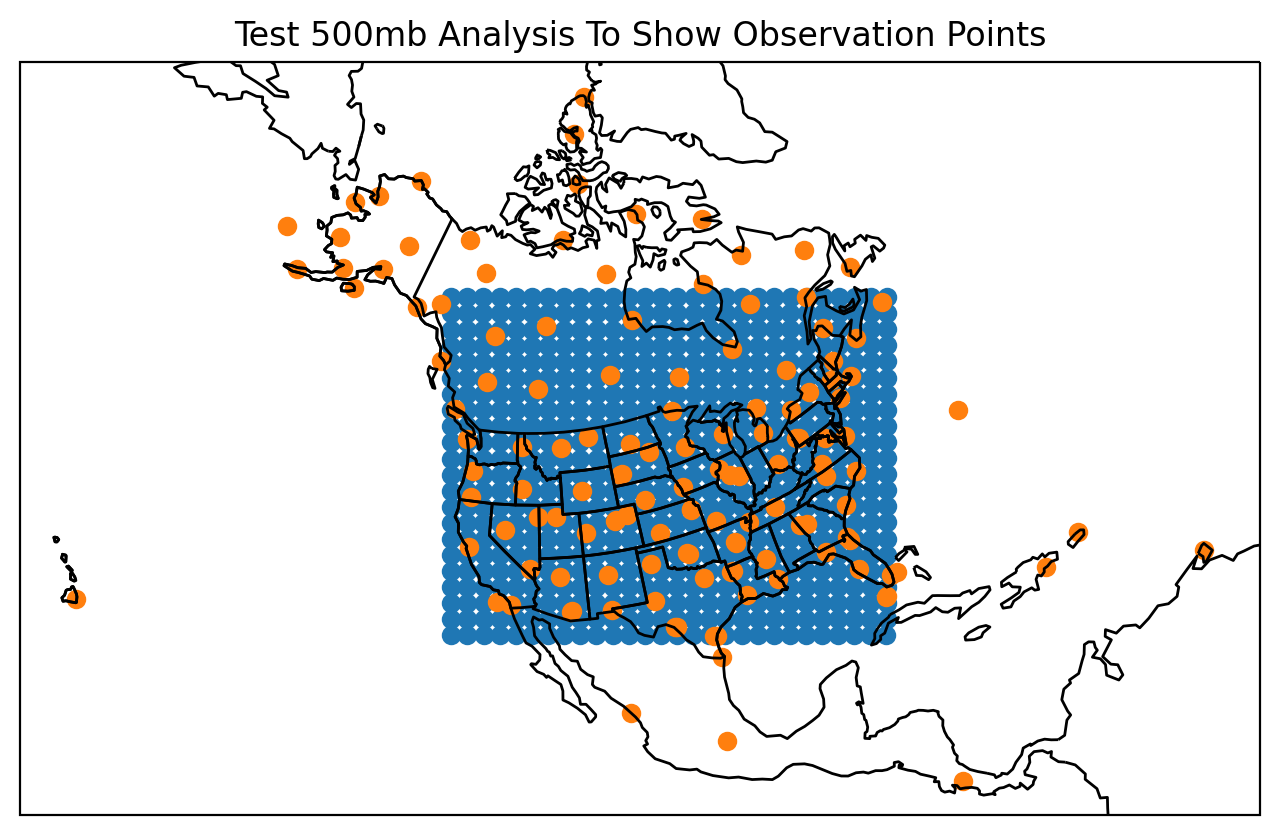

In [13]:
#Plot 500mb analyses with lat/lon to make sure it is working
#Blue dots are the grid that was created, orange dots are where there are upper air observations

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(new_lon.ravel(), new_lat.ravel(), transform = ccrs.PlateCarree())
ax1.scatter(obs_lon, obs_lat, transform = ccrs.PlateCarree())
plt.title('Test 500mb Analysis To Show Observation Points')
plt.show()

In [14]:
#Find dmin
empty_dmin = np.zeros(len(x_obs))

for i in range(135):
    r = ((x_obs[i] - x_obs)**2 + (y_obs[i] - y_obs)**2)**(1/2)
    r.sort()
    empty_dmin[i] = r[1]

real_dmin = np.mean(empty_dmin) #2.55

In [15]:
#Find Radius of Influences
R1 = 4*real_dmin
R2 = 2.5*real_dmin
R3 = 1.5*real_dmin

Roi_array = np.array([R1, R2, R3]) #the radius of influence values put in an array for easy indexing

In [16]:
#Complete the first pass

#Create empty matrices to store the data (22x28 matrix)
x_columns = 28
y_rows = 22
analysis_matrix = np.zeros((x_columns,y_rows,len(Roi_array))) #this stores the analysis values in the matrix

for j in range(len(grid_x)): #going through the length of the x grid
    for k in range(len(grid_x[0])): #going through the values of the x grid, and it keeps going through the other values remaining
        x_dist = grid_x[j,k] - x_obs #finding the x distance
        y_dist = grid_y[j,k] - y_obs #finding the y distance
        radius = ((x_dist)**2 + (y_dist)**2)**(1/2) #this is the distance formula
        impt_vals = np.where(radius <= Roi_array[0]) #these are are the obs in the radius of influence
        weights = np.zeros(len(x_obs)) #create an empty array to hold the weights
        
        for l in impt_vals[0]: #this goes through the observations in the radius of influence
            w = Cressman(radius[l], Roi_array[0]) #do the Cressman function
            weights[l] = w #plug these values into the empty array
        
        analysis_matrix[j,k,0] = np.sum(weights * obs_ht) / np.sum(weights) #this is the completed first pass
                                                                            #Thi is taking the sum of the weights * the observational heights, then divided by the sum of the weights (weighting funct)

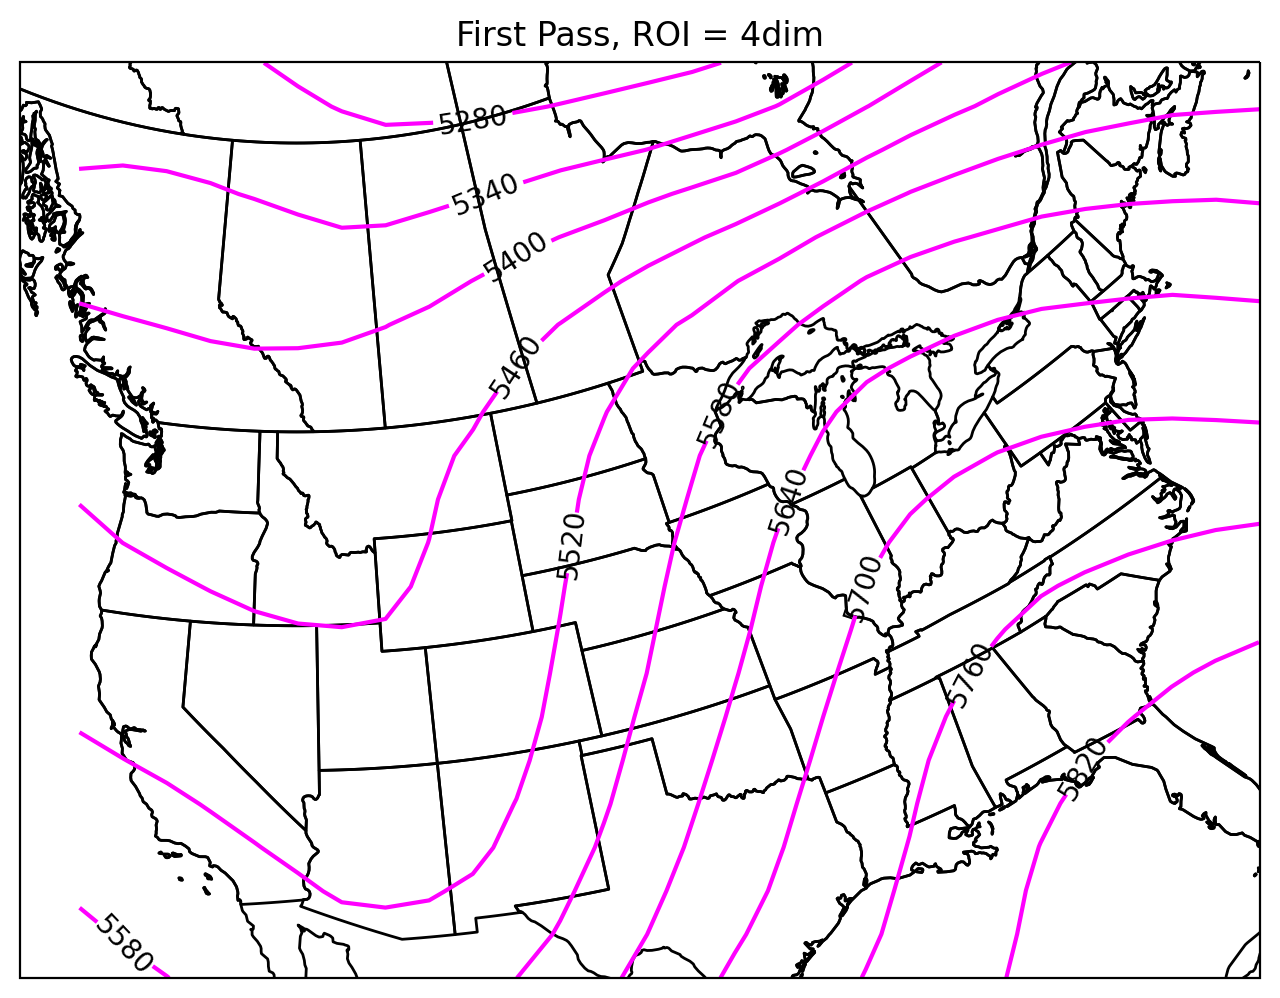

<Figure size 432x288 with 0 Axes>

In [17]:
#Plot the first pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_matrix[:,:,0],colors='fuchsia',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60), colors = 'black')
plt.title('First Pass, ROI = 4dim')
plt.show()
plt.savefig("first_pass")

In [18]:
#Complete the second pass

#Setup for the second pass
ind_x = ((x_obs - x)/delta_x) #x coordinate for observations - xo divided by the spacing of the points
ind_y = ((y_obs - y)/delta_y) #y coordinate for observations - yo divided by the spacing of the points

P1 = np.zeros(len(x_obs)) #create an empty array to store the bilinear information

#Below is the setup stating if the observation is in the grid, use bilinear. If the observation is not in the grid, do reverse Cressman

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):   #observation is in the grid, use bilinear
        p = bilinear(ind_x[i], ind_y[i], 0) #the zero is using your analysis values from your first pass
    else:
        x_dist_a = x_obs[i] -  grid_x  #observation not in grid, use a reverse Cressman
        y_dist_a = y_obs[i] - grid_y  
        radius_a = ((x_dist_a)**2 + (y_dist_a)**2)**(1/2)
        impt_vals_a = np.where(radius_a <= Roi_array[0])
        weights_a = np.zeros(grid_x.shape) #Make the grid
        for j in impt_vals_a[0]: #going through the columns in the grid
            for k in impt_vals_a[1]: #going through the other column in the grid
                weights_cressman_a = Cressman(radius_a[j,k], Roi_array[0]) #do the Cressman
                weights_a[j,k] = weights_cressman_a
        p = np.sum(weights_a * analysis_matrix[:,:,0])/np.sum(weights_a) #this is the equation (fa-1)(rk). Need to do because no background
        
    P1[i] = p
    
#####################################################################################################################################################################################
for j in range(len(grid_x)): #going through the length of the x grid
    for k in range(len(grid_x[0])): #going through the values of the x grid, and it keeps going through the other values remaining
        x_dist = grid_x[j,k] - x_obs #finding the x distance
        y_dist = grid_y[j,k] - y_obs #finding the y distance
        radius = ((x_dist)**2 + (y_dist)**2)**(1/2) #this is the distance formula
        impt_vals = np.where(radius <= Roi_array[1])[0] #these are are the obs in the radius of influence
        weights = np.zeros(len(x_obs))
        
        for l in impt_vals:
            w = Cressman(radius[l], Roi_array[1]) #this is doing the reverse Cressman
            weights[l] = w
        
        analysis_matrix[j,k,1] = analysis_matrix[j,k,0] + np.nansum(weights*(obs_ht - P1)) / np.nansum(weights) #this is the second pass
                                                                                                                #The equation is (the analysis value at the analysis location is equal to the
                                                                                                                #analysis matrix minut the sum of the weights * the observational height * the result
                                                                                                                #from bilinear, all divided by the sum of the weights

/var/folders/m9/yb2h4dzn23x_vrjkp3s28x_h0000gn/T/ipykernel_1232/2651162688.py:24: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_a * analysis_matrix[:,:,0])/np.sum(weights_a) #this is the equation (fa-1)(rk). Need to do because no background


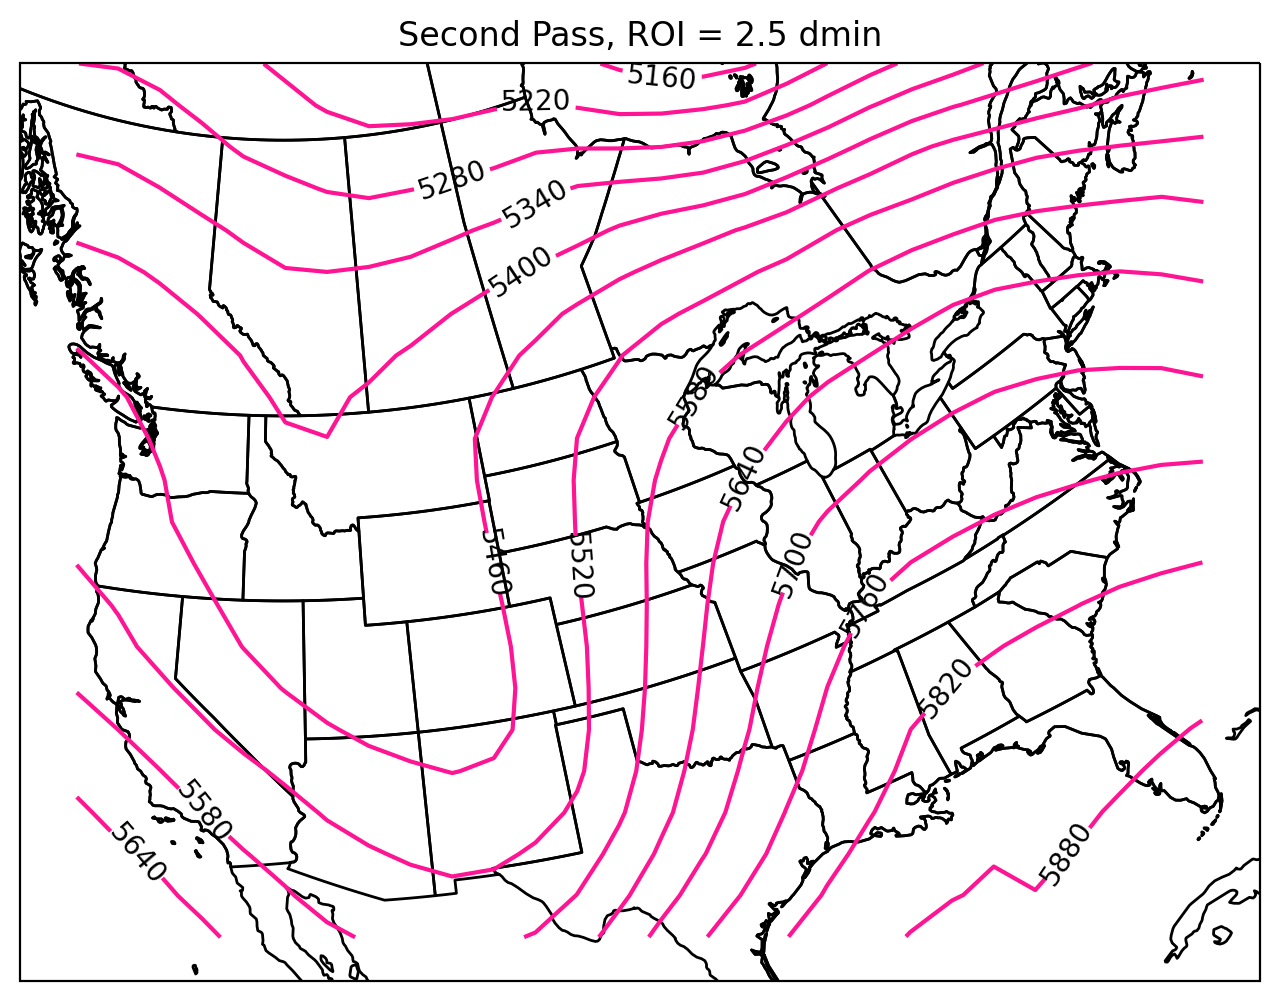

In [19]:
#Contour plot of the second pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_matrix[:,:,1],colors='deeppink',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60), colors = 'black')
plt.title('Second Pass, ROI = 2.5 dmin')
plt.show()

In [20]:
#Complete the 3rd pass

ind_x = ((x_obs - x)/delta_x) #x coordinate for observations - xo divided by the spacing of the points
ind_y = ((y_obs - y)/delta_y) #y coordinate for observations - yo divided by the spacing of the points

P2 = np.zeros(len(x_obs)) #empty array to store bilinear

#This is the analysis value setup (same setup as Second Pass, just changing the ROI to the last value

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):   #observation is in the grid, use bilinear
        p = bilinear(ind_x[i], ind_y[i], 1) #the zero is using your analysis values from your first pass  
    else:
        x_dist_a = x_obs[i] -  grid_x  #observation not in grid, use a reverse Cressman
        y_dist_a = y_obs[i] - grid_y  
        radius_a = ((x_dist_a)**2 + (y_dist_a)**2)**(1/2)
        impt_vals_a = np.where(radius_a <= Roi_array[1])
        weights_a = np.zeros(grid_x.shape) #Make the grid
        for j in impt_vals_a[0]: #going through the columns in the grid
            for k in impt_vals_a[1]: #going through the other column in the grid
                weights_cressman_a = Cressman(radius_a[j,k], Roi_array[1]) 
                weights_a[j,k] = weights_cressman_a
        p = np.sum(weights_a * analysis_matrix[:,:,1])/np.sum(weights_a)
        
    P2[i] = p

########################################################################################################################################################################################################
for j in range(len(grid_x)): #going through the length of the x grid
    for k in range(len(grid_x[0])): #going through the values of the x grid, and it keeps going through the other values remaining
        x_dist = grid_x[j,k] - x_obs #finding the x distance
        y_dist = grid_y[j,k] - y_obs #finding the y distance
        radius = ((x_dist)**2 + (y_dist)**2)**(1/2) #this is the distance formula
        impt_vals = np.where(radius <= Roi_array[2])[0] #these are are the obs in the radius of influence
        weights = np.zeros(len(x_obs))
        
        for l in impt_vals:
            w = Cressman(radius[l], Roi_array[2])
            weights[l] = w
        
        analysis_matrix[j,k,2] = analysis_matrix[j,k,1] + np.nansum(weights*(obs_ht - P2)) / np.nansum(weights) #this is the 3rd pass
                                                                                                                #Same setup as the 2nd pass, except now it is the bilinear result from the 3rd

/var/folders/m9/yb2h4dzn23x_vrjkp3s28x_h0000gn/T/ipykernel_1232/1951946000.py:23: RuntimeWarning: invalid value encountered in double_scalars
  p = np.sum(weights_a * analysis_matrix[:,:,1])/np.sum(weights_a)
/var/folders/m9/yb2h4dzn23x_vrjkp3s28x_h0000gn/T/ipykernel_1232/1951946000.py:40: RuntimeWarning: invalid value encountered in double_scalars
  analysis_matrix[j,k,2] = analysis_matrix[j,k,1] + np.nansum(weights*(obs_ht - P2)) / np.nansum(weights) #this is the 3rd pass


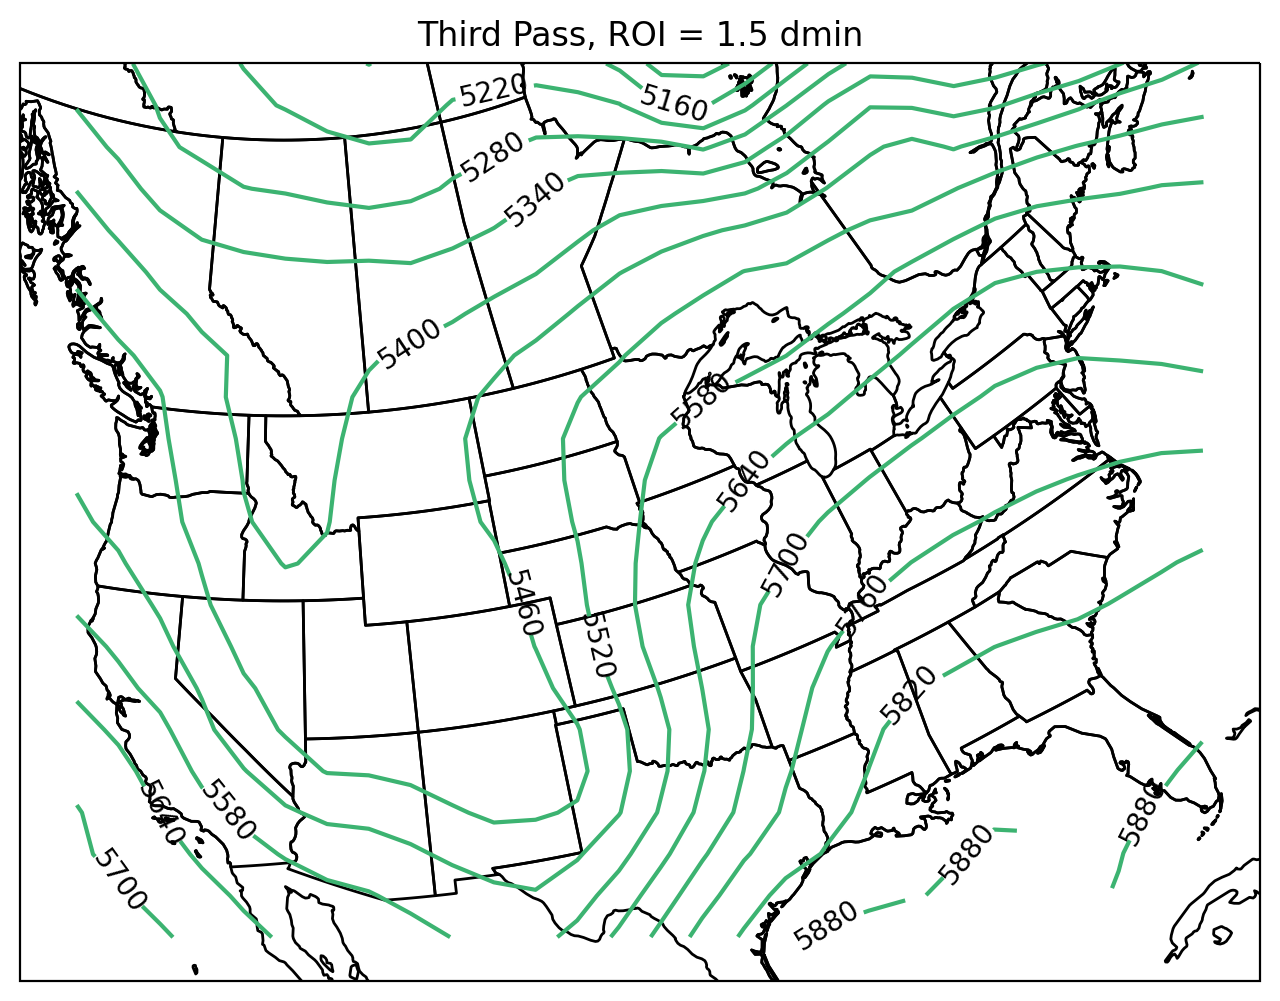

In [21]:
#Plot the 3rd pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_matrix[:,:,2],colors='mediumseagreen',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60), colors = 'black')
plt.title('Third Pass, ROI = 1.5 dmin')
plt.savefig("third_pass")
plt.show()

In [22]:
#Calculate P3
ind_x = ((x_obs - x)/delta_x) #x coordinate for observations - xo divided by the spacing of the points
ind_y = ((y_obs - y)/delta_y) #y coordinate for observations - yo divided by the spacing of the points

P3 = np.zeros(len(x_obs)) #empty array to store bilinear

#This is the analysis value setup (same setup as Second Pass, just changing the ROI to the last value

for i in range(len(ind_x)):
    if (ind_x[i] >= 0) and (ind_x[i] < 21) and (ind_y[i] >= 0) and (ind_y[i] < 27):   #observation is in the grid, use bilinear
        p = bilinear(ind_x[i], ind_y[i], 2) #the zero is using your analysis values from your first pass
    else:
        x_dist_a = x_obs[i] -  grid_x  #observation not in grid, use a reverse Cressman
        y_dist_a = y_obs[i] - grid_y  
        radius_a = ((x_dist_a)**2 + (y_dist_a)**2)**(1/2)
        impt_vals_a = np.where(radius_a <= Roi_array[2])
        weights_a = np.zeros(grid_x.shape) #Make the grid
        for j in impt_vals_a[0]: #going through the columns in the grid
            for k in impt_vals_a[1]: #going through the other column in the grid
                weights_cressman_a = Cressman(radius_a[j,k], Roi_array[2])
                weights_a[j,k] = weights_cressman_a
        p = np.sum(weights_a * analysis_matrix[:,:,2])/np.sum(weights_a)
        
    P3[i] = p

In [23]:
#Calculate Analysis Differences
#Analysis_matrix is 0,1,2

second_analysis = analysis_matrix[:,:,1]
first_analysis = analysis_matrix[:,:,0]
third_analysis = analysis_matrix[:,:,2]

#Analysis 2 - Analysis 1
analysis_2_1_diff = second_analysis - first_analysis

#Analysis 3 - Analysis 1
analysis_3_1_diff = third_analysis - first_analysis

#Analysis 3 - Analysis 2
analysis_3_2_diff = third_analysis - second_analysis

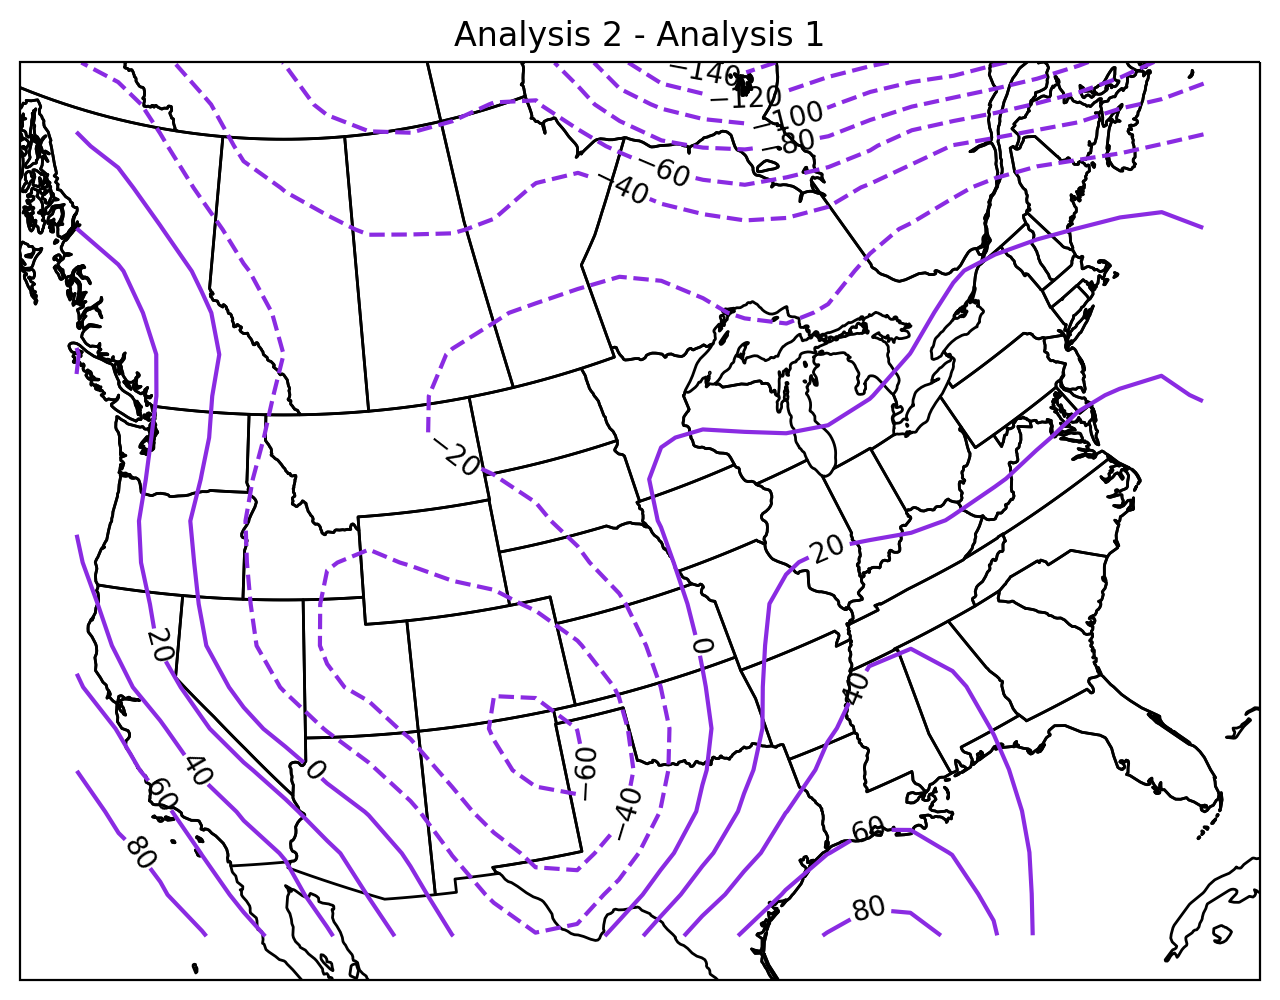

In [24]:
#Plot the Analysis 2 - Analysis 1
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_2_1_diff,colors='blueviolet',levels=np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,20), colors = 'black')
plt.title('Analysis 2 - Analysis 1')
plt.savefig("analysis_2_1")
plt.show()

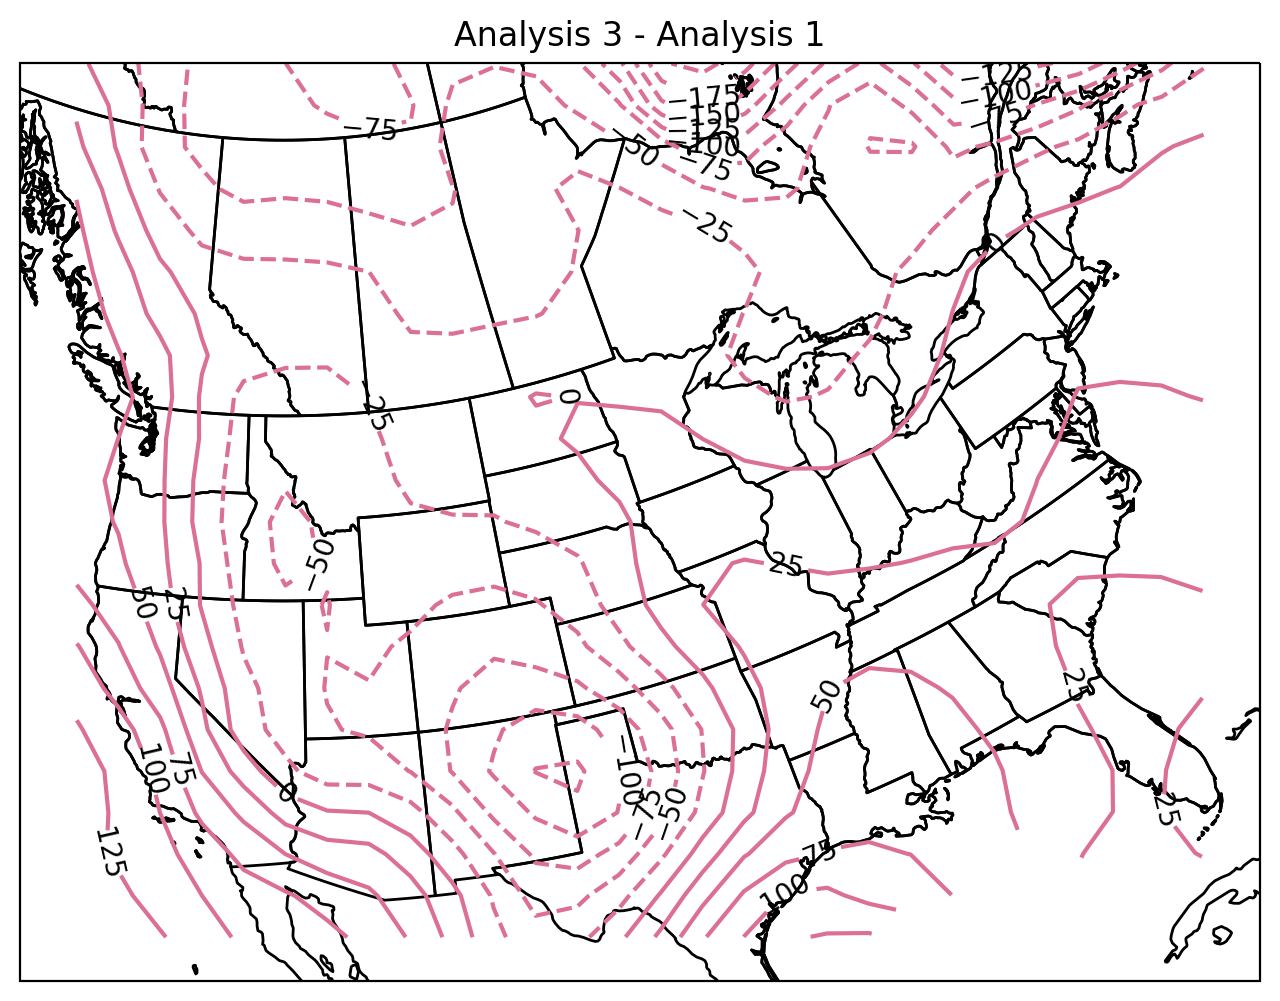

In [25]:
#Plot the Analysis 3 - Analysis 1
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_3_1_diff,colors='palevioletred',levels=np.arange(-8000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,25), colors = 'black')
plt.title('Analysis 3 - Analysis 1')
plt.savefig("Analysis_3_1")
plt.show()

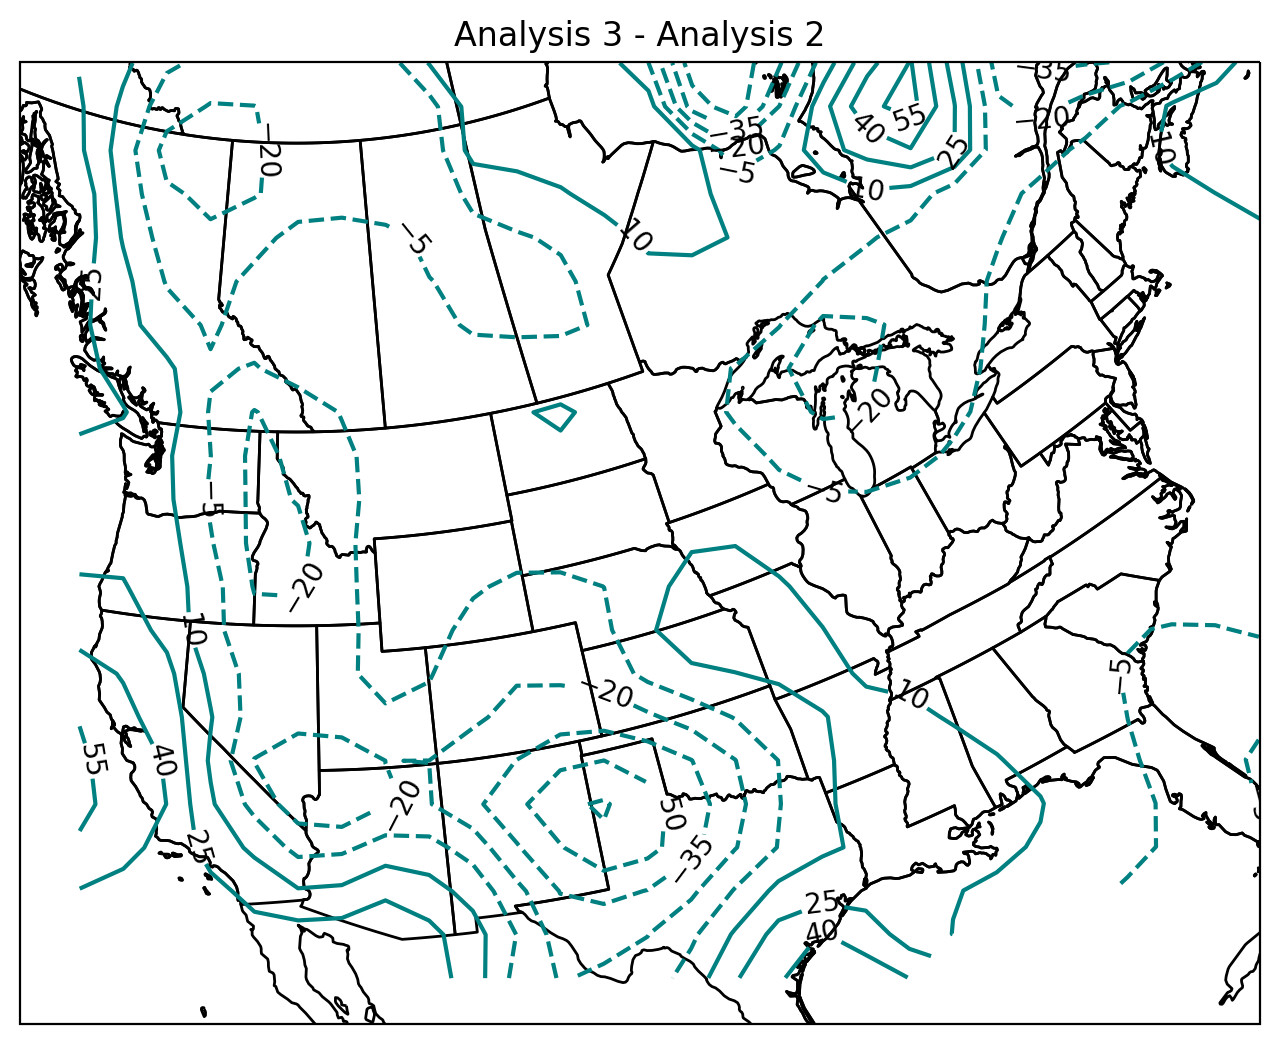

In [26]:
#Plot the Analysis 3 - Analysis 2
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(new_lon,new_lat,analysis_3_2_diff,colors='teal',levels=np.arange(-8000,8000,15),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-8000,8000,15), colors = 'black')
plt.title('Analysis 3 - Analysis 2')
plt.savefig("Analysis_3_2")
plt.show()

In [27]:
#Compute the root mean square differences between the analyses and observations for each analysis pass
#jrms = sqrt((sum((fo - fa)^2)) / K)

#Root mean square diff for Analysis 1
diff_1 = (obs_ht - P1)**2
diff_1 = diff_1[~np.isnan(diff_1)]
rms_1 = np.sqrt((np.sum(diff_1))/len(diff_1))

#Root mean square diff for Analysis 2
diff_2 = (obs_ht - P2)**2
diff_2 = diff_2[~np.isnan(diff_2)]
rms_2 = np.sqrt((np.sum(diff_2))/len(diff_2))

#Root mean square diff for Analysis 3
diff_3 = (obs_ht - P3)**2
diff_3 = diff_3[~np.isnan(diff_3)]
rms_3 = np.sqrt((np.sum(diff_3))/len(diff_3))

rms_list = list([rms_1, rms_2, rms_3])

In [28]:
#Store the analyses in text files
a_file = open("Analysis_Matrix_ROI_4dmin", "w")
for line in analysis_matrix[:,:,0]:
    np.savetxt(a_file, line)
    
b_file = open("Analysis_Matrix_ROI_2.5dmin", "w") 
for line in analysis_matrix[:,:,1]:
    np.savetxt(b_file, line)
    
c_file = open("Analysis_Matrix_ROI_1.5dmin", "w") 
for line in analysis_matrix[:,:,2]:
    np.savetxt(c_file, line)

In [29]:
#Store the difference fields in text files

d_file = open("Analysis_2_1_diff", "w")
for line in analysis_2_1_diff:
    np.savetxt(d_file, line)
    
e_file = open("Analysis_3_1_diff", "w") 
for line in analysis_3_1_diff:
    np.savetxt(e_file, line)
    
f_file = open("Analysis_3_2_diff", "w") 
for line in analysis_3_2_diff:
    np.savetxt(f_file, line)

In [30]:
#Store RMS values in text file
np.savetxt("RMS_values.txt", rms_list)

In [31]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

    In the first pass, there is a trough over Arizona, New Mexico, Utah and Idaho (basically the states above Arizona/New Mexico. There is a slight ridge over the southeast (Georgia
    northward through the northeast of the US). The 5400 height line is in Canada, which means the values lower than 5400 include temperatures below freezing. In general, the
    temperatures where the trough is located in colder than the temperatures where the ridge is. The spacing between the isobars is wider between the 5520 and 5460 line, with 
    some isobars closer in northen Canada. The spread of the isobars in the southeast is wise, indicating not a large pressure gradient. There is also a random 5580 contour
    off the south of California. Other than the random contour, the first pass contour looks nice.
    
    In the second pass, the first standout and difference is the more rugged contours. The deep trough is still located over New Mexico/Arizona and northward and the ridge is 
    still over the southeast and northward. The 5400 contour has moved more southward, with a part of it in Montana. The 5460 contour is now the main one over Utah and Colorado.
    Off the coast of Florida, there is a weird 5580 contour, more rigid, along with the 5640 and 5580 contour off the south of California. The contours are also closer together
    up in Canada, as well as a bit closer together in Texas, Oklahoma.
    
    In the third pass, the trough and ridge pattern is still there, but now the trough dips deeper into New Mexico and Arizona, and the ridge tilts more to the left. The 5400
    contour is deeper, now into Idaho and western Montana. There are more broken 5880 contours off the coast off the coast of Texas.
    
2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    Looking between the first pass and the second pass, the first pass looks smoother than the second pass. The first pass has contours further apart compared to the second pass,
    while the second pass also has weird contours off of Florida and California. Looking at the Analysis 2 - Analysis 1 image, there is a large difference in the contour values
    where the trough is located, and increased contour values over the south.
    
    Between the second and thrid pass, the contours are closer together in both images compared to the first pass. In the second pass, the main trough dips lower than the first
    pass, while the third pass has the trough dip the deepest. Comparing the Analysis 3 - Analysis 2 image, over northern Texas there are higher pressure values, with lower pressure
    values over Idaho/Utah.
    
    Finally, for the Analysis 3 - Analysis 1, there are substantially lower pressure values over the northwest of Texas and over New Mexico/Arizona. Higher pressure values
    are found over the general eastern United States.
    
    The smoothest is Analysis 1. The reason why Analysis 1 is the smoothest is because this analysis is basically a "low-pass" filter. This means that everything (small scale
    features) are smoothed out, which then makes the large scale features just look nicer. All of the smaller scale features become less defined, which is probably why
    the isobars are further apart compared to the other two passes.

3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
    
    When you increase the number of passes, the smaller scale features are enhanced. When comparing the images from the first pass and the third pass, there are more features
    to be seen in the third pass, as the isobars are closer together and there are more "kinks" in the isobars. The enhancement of small scale features may or may not be
    desirerable. If trying to see the larger scale features, then one pass is fine. To truly understand the weather patterns, then more passes would be best. Doing more passes
    however led to weird contours. To analyze weather patterns, more passes would be better.
    

'''

'\n1 - Describe the general features that you see in your contoured analyses.\n\n    In the first pass, there is a trough over Arizona, New Mexico, Utah and Idaho (basically the states above Arizona/New Mexico. There is a slight ridge over the southeast (Georgia\n    northward through the northeast of the US). The 5400 height line is in Canada, which means the values lower than 5400 include temperatures below freezing. In general, the\n    temperatures where the trough is located in colder than the temperatures where the ridge is. The spacing between the isobars is wider between the 5520 and 5460 line, with \n    some isobars closer in northen Canada. The spread of the isobars in the southeast is wise, indicating not a large pressure gradient. There is also a random 5580 contour\n    off the south of California. Other than the random contour, the first pass contour looks nice.\n    \n    In the second pass, the first standout and difference is the more rugged contours. The deep trough 